# Wavelets

In [1]:
from scipy.signal import butter, lfilter
from sklearn import preprocessing
import pandas as pd
from pathlib import Path
import pywt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set_theme()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

Helper function for visualization

Load data

In [2]:
fpath = Path("/home/mst/projects/flyps/myalyce/data/Unfiltered PPG, plus accelerometer/PPG_JoshuaBrewster2023-06-14T15_48_32.828(UTC-07_00).csv")
df = pd.read_csv(fpath)
df

,timestamp,localized,red,ir
0,1686782913042,2023-06-14T15:48:33.042(UTC-07:00),26462,44429
1,1686782913041,2023-06-14T15:48:33.041(UTC-07:00),26465,44426
2,1686782913040,2023-06-14T15:48:33.040(UTC-07:00),26458,44411
3,1686782913039,2023-06-14T15:48:33.039(UTC-07:00),26457,44406
4,1686782913037,2023-06-14T15:48:33.037(UTC-07:00),26457,44407
...,...,...,...,...
2555,1686782963623,2023-06-14T15:49:23.623(UTC-07:00),26601,44406
2556,1686782963643,2023-06-14T15:49:23.643(UTC-07:00),26601,44401
2557,1686782963663,2023-06-14T15:49:23.663(UTC-07:00),26601,44391
2558,1686782963683,2023-06-14T15:49:23.683(UTC-07:00),26587,44348


Visualize the `red` dataset

<Axes: >

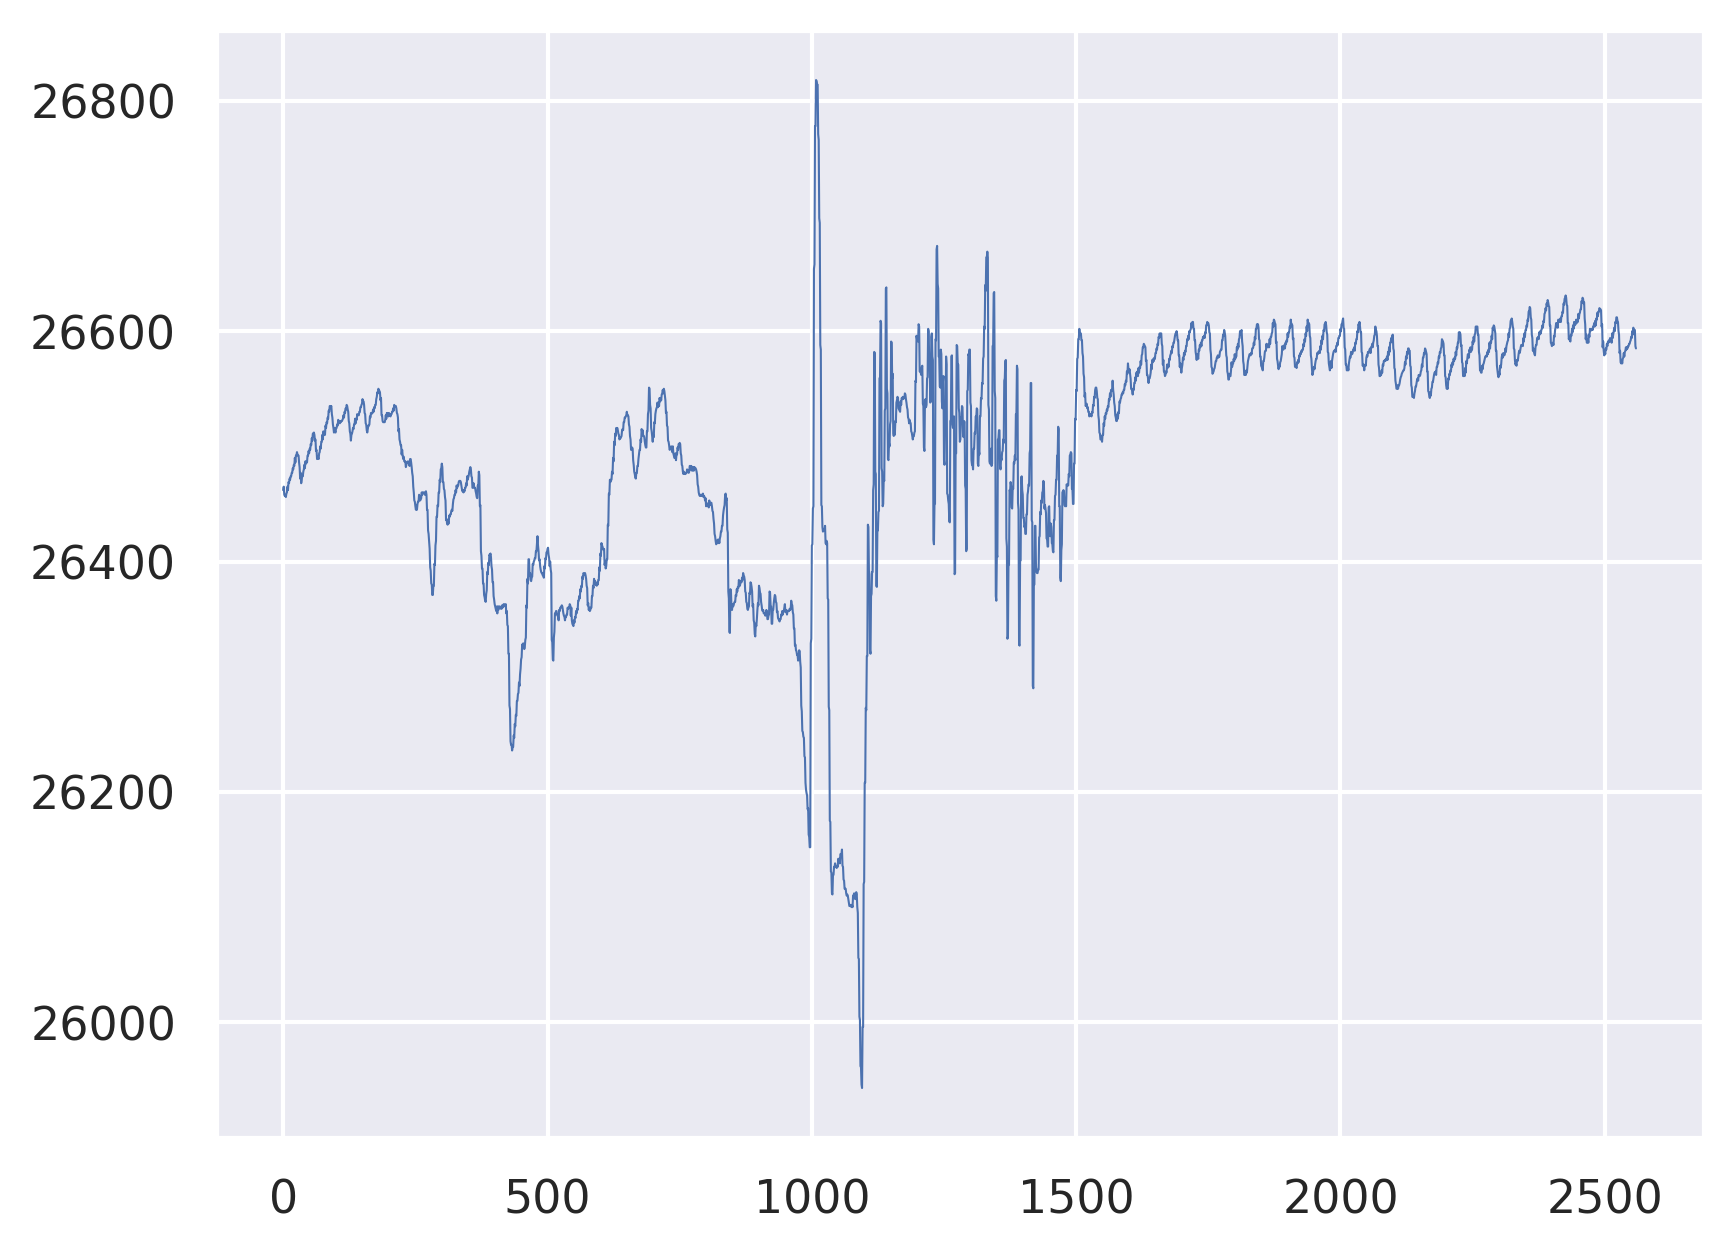

In [3]:
df['red'].plot(lw=0.5)

`decompose()` implements the `wavedec()` function from the pyWavelets library.

In [35]:
def decompose(sgnl: np.array, level: int, dec_high: np.array, dec_low: np.array) -> list:
    padlen = len(dec_low)
    sg = np.pad(sgnl, padlen, mode='edge')
    ca = np.convolve(sg, dec_low, mode='full')[1+padlen:-padlen:2]
    cd = np.convolve(sg, dec_high, mode='full')[1+padlen:-padlen:2]
    out = [cd]
    for i in range(level-1):
        ca = np.pad(ca, padlen, mode='edge')
        out.append(np.convolve(ca, dec_high, mode='full')[1+padlen:-padlen:2])
        ca = np.convolve(ca, dec_low, mode='full')[1+padlen:-padlen:2]
    return [ca] + list(reversed(out))

In [36]:
data = df['red']
w = pywt.Wavelet('sym4')
dec_lo, dec_hi, rec_lo, rec_hi = w.filter_bank
maxlev = pywt.dwt_max_level(len(data), w.dec_len)
coeffs = decompose(data, level=maxlev, dec_high=dec_hi, dec_low=dec_lo)


In [16]:
min_max_scaler = preprocessing.MinMaxScaler()

garrote is a kind of soft threshold. To illustrate it:

In [17]:
x = [1,2,3,4,5]
pywt.threshold(data=x, value=2, mode='garrote')

array([0.        , 0.        , 1.66666667, 3.        , 4.2       ])

Threshold the coefficients from 3 to 9 - leave 1 and 2 untouched. Set the threshold to 0.1 * max value of each coefficient level.
Copy the coefficients to not overwrite them when running multiple times.

In [37]:
cfs = coeffs.copy()
for i in range(3, len(cfs)):
        cfs[i] = pywt.threshold(cfs[i], 0.1*np.max(cfs[i]), 'garrote')

Recreate the signal with modified coefficients.

In [38]:
red = np.array(df['red'])
recreated = pywt.waverec(cfs, w)
signal = red-recreated

Visualize

Text(0.5, 1.0, 'Recreated signal')

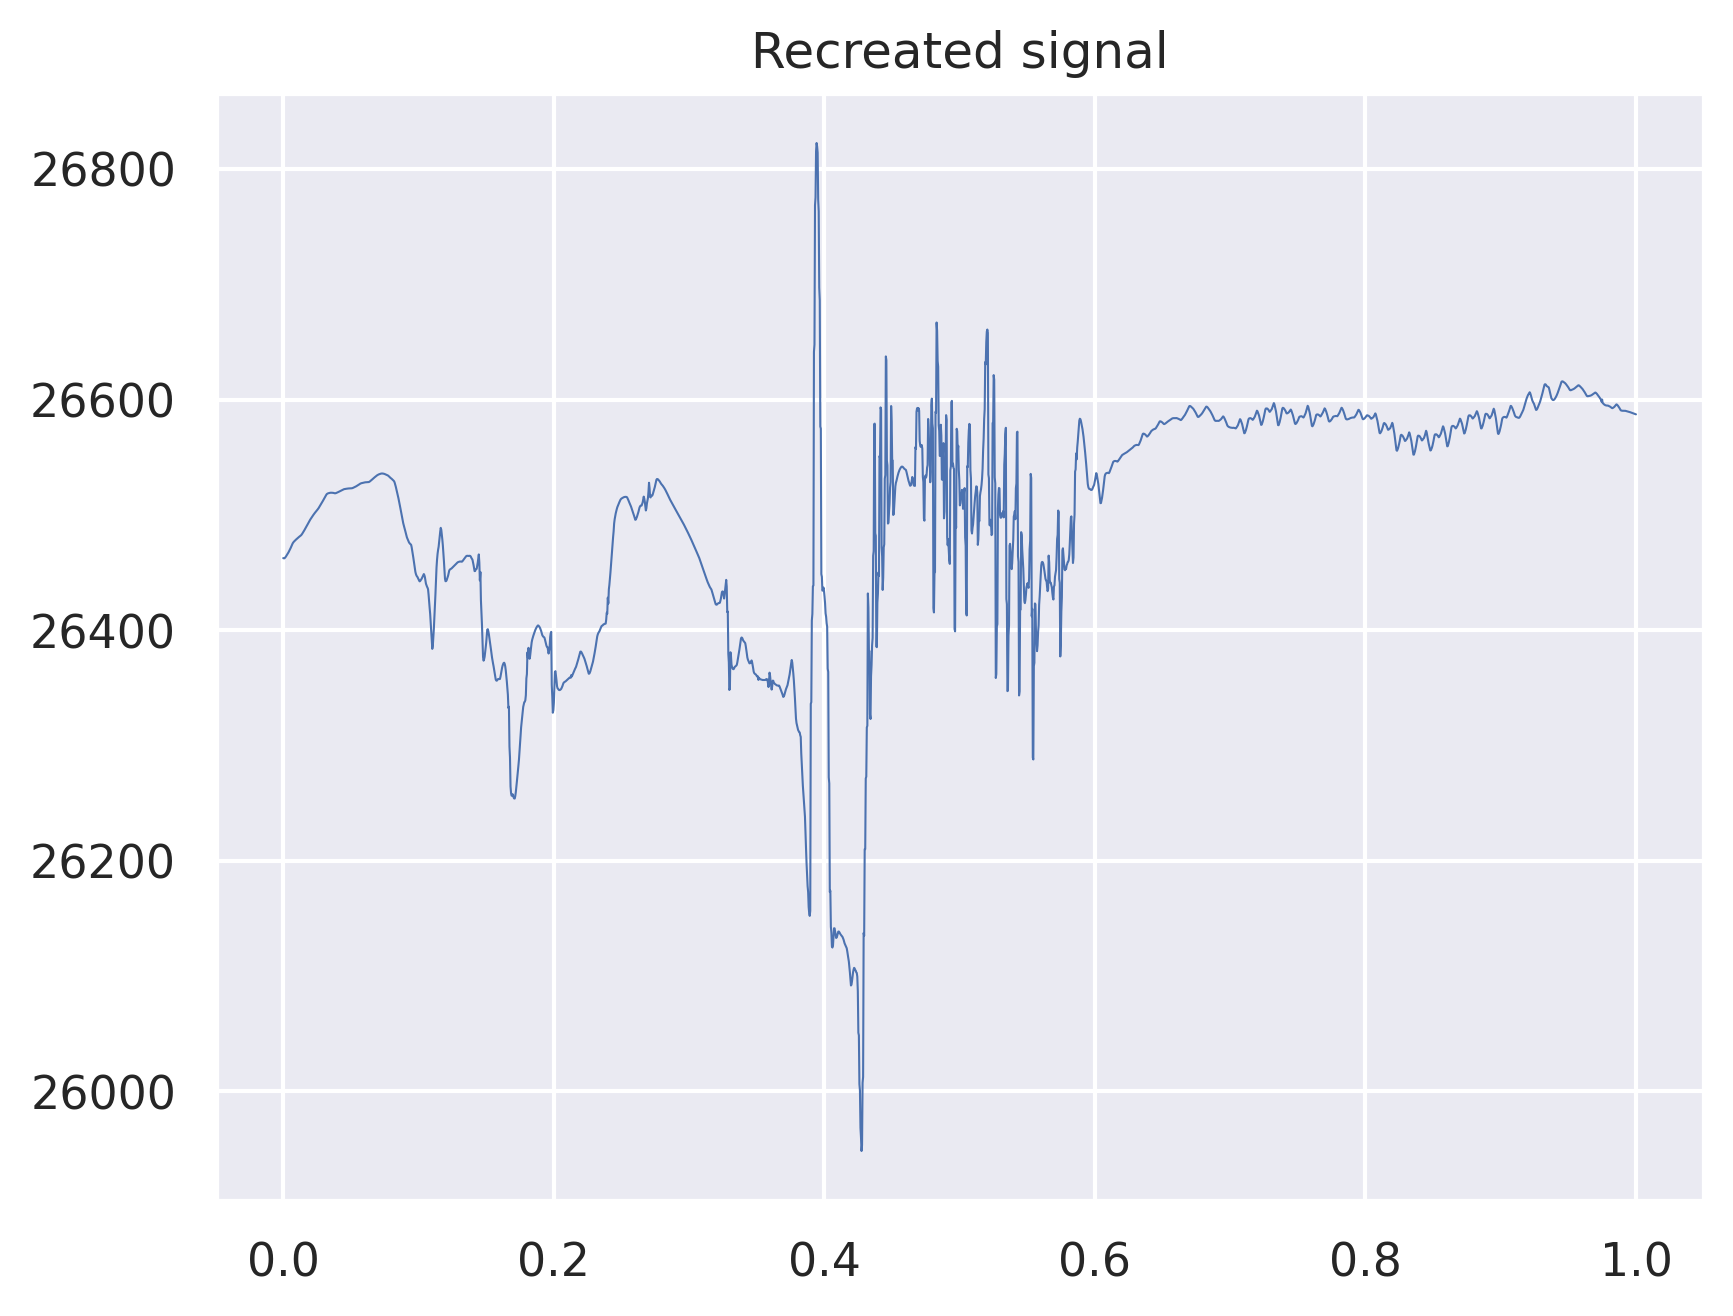

In [39]:
plt.plot(np.linspace(0, 1., num=len(recreated)), recreated, lw=0.5)
plt.title('Recreated signal')

Text(0.5, 1.0, 'original minus recreated')

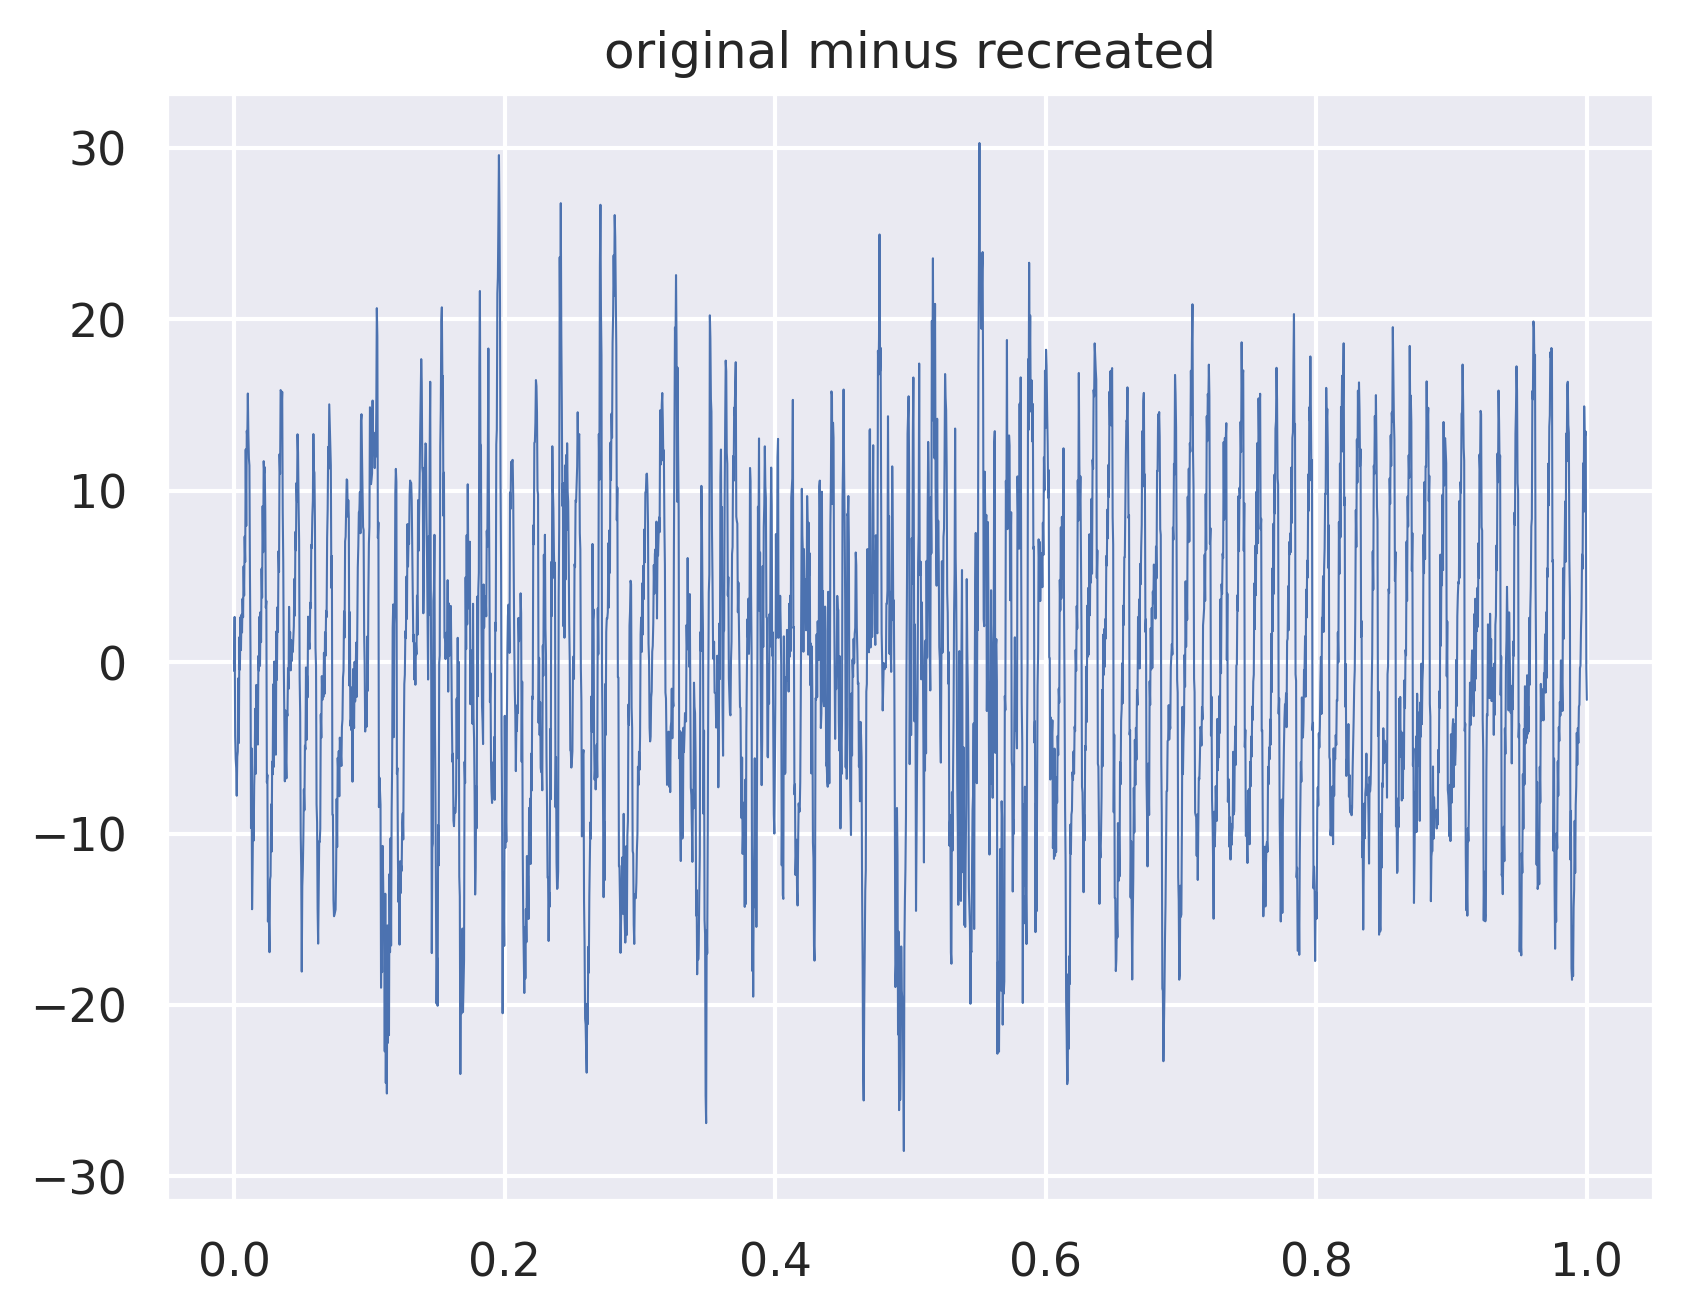

In [40]:
plt.plot(np.linspace(0, 1., num=len(signal)), signal, lw=0.5)
plt.title('original minus recreated')

Work in progress

In [11]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [12]:
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S.%f(UTC-07:00)"
df['dt'] = pd.to_datetime(df['localized'], format=DATE_FORMAT)

In [13]:
# Filter requirements.
order = 8

t = df['dt'].max() - df['dt'].min()

fs = len(df)/t.seconds       # sample rate, Hz

cutoff = 2  # desired cutoff frequency of the filter, Hz

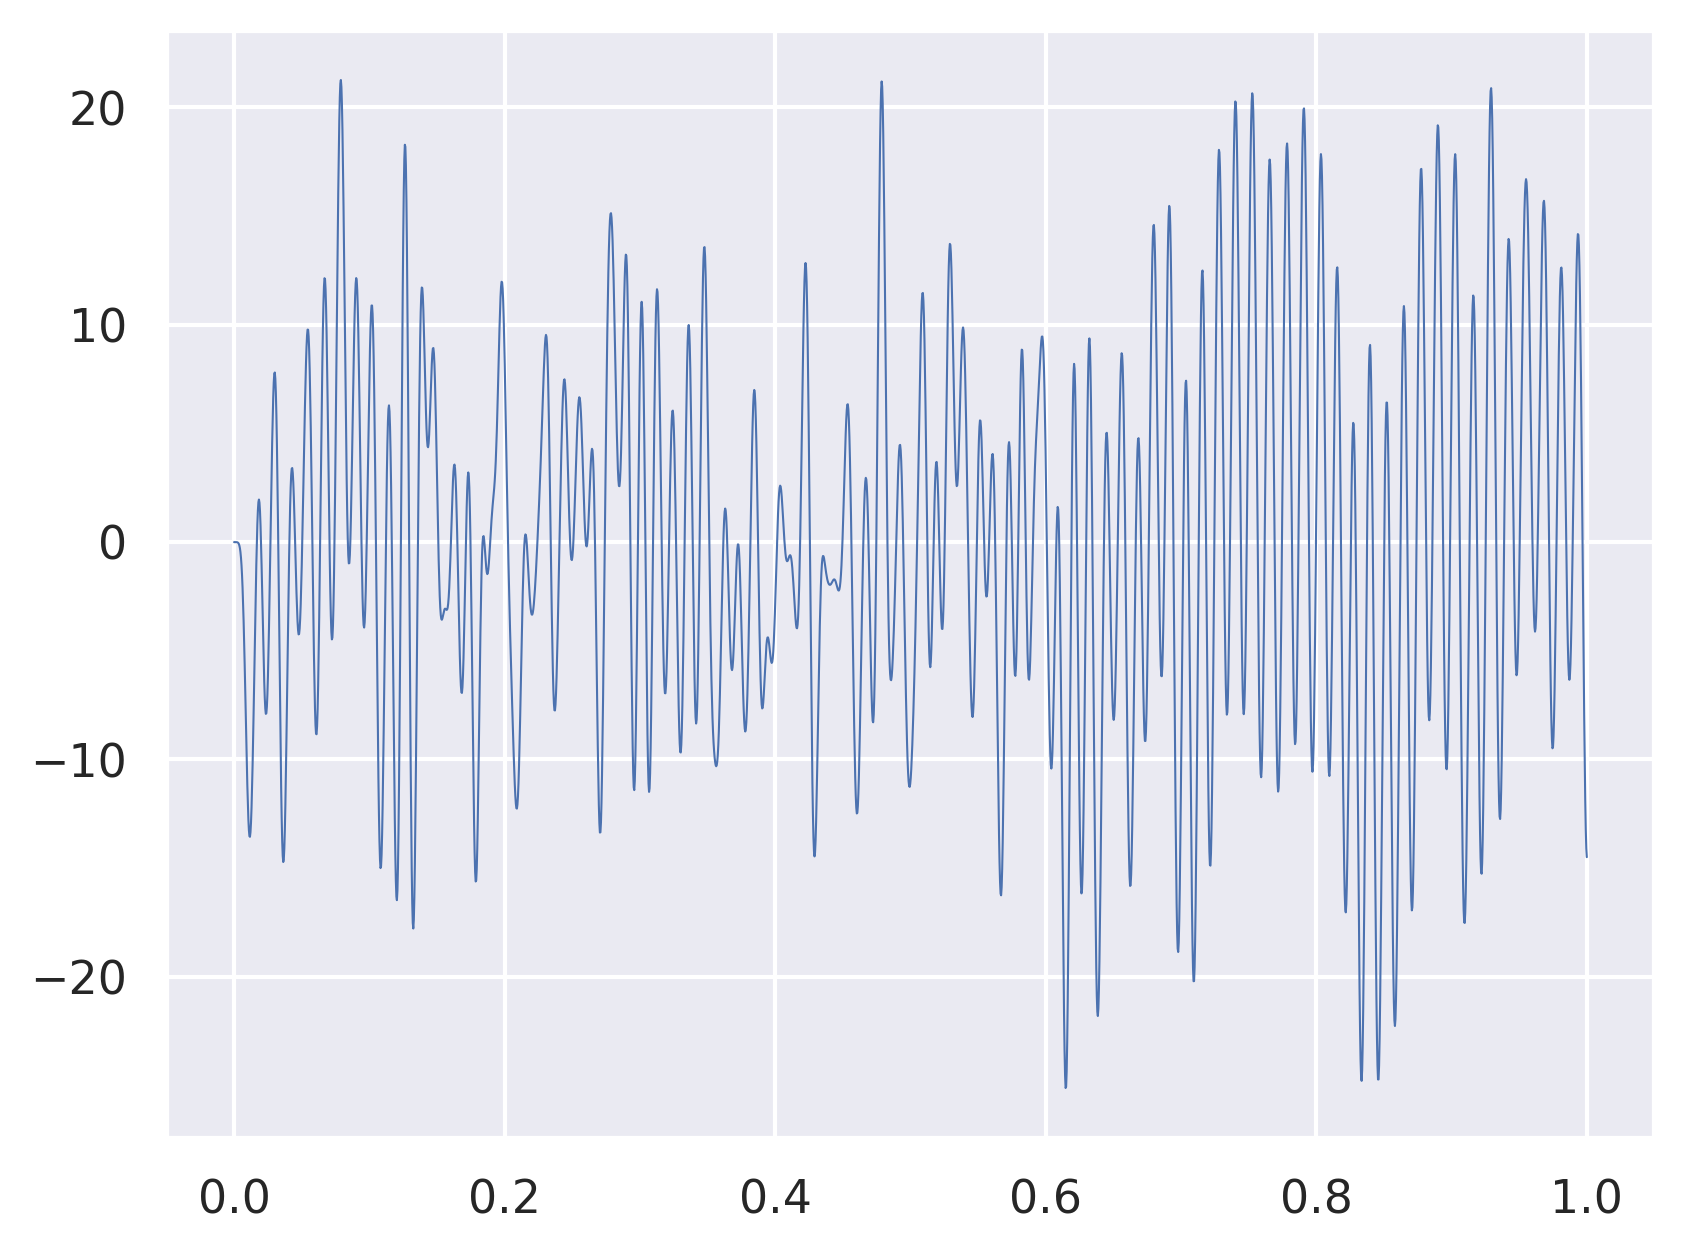

In [14]:

b, a = butter_lowpass(cutoff, fs, order)

y = butter_lowpass_filter(signal, cutoff, fs, order)

plt.plot(np.linspace(0, 1., num=len(y)), y, lw=0.5)
ax = plt.gca()
